In [57]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from scipy.signal import filtfilt
from scipy.sparse.linalg import lsqr
from pylops.basicoperators import *
from pylops.optimization.leastsquares import *

from refrtomo.gaussnewton import gauss_newton
from refrtomo.invert import *
from refrtomo.survey import *


import segyio
from refrtomo.segyshot import SegyShot
from refrtomo.VolvoHelper import *
from refrtomo.picking import *
from refrtomo.segyshot import SegyShot, rotate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Volvo Dataset Velocity Model

Local regular axis:
 ox=0.000000, dx=49.793406 nx=241
 oy=-0.000000, dy=49.540976 ny=109


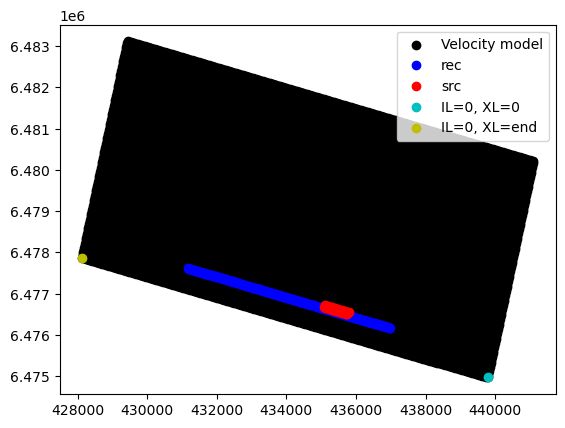

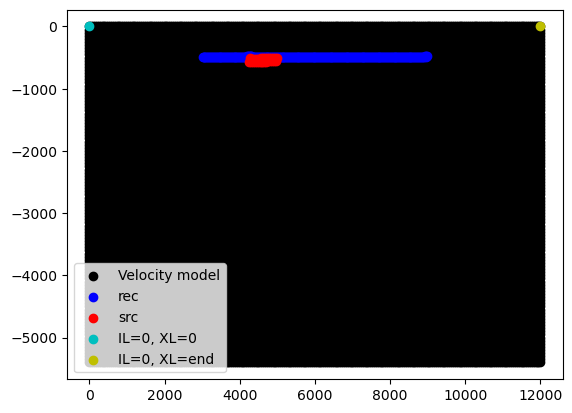

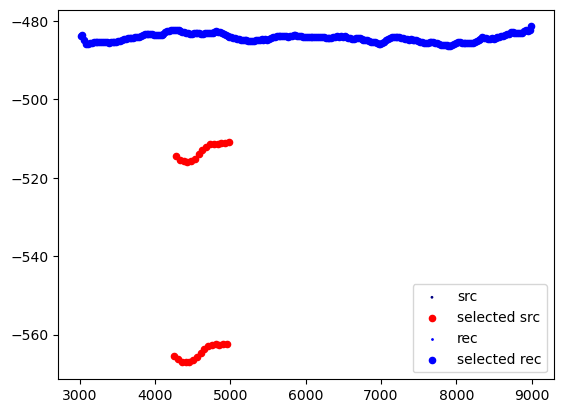

In [2]:
inputfile = '../data/ST10010_1150780_40203_2dline1.sgy'
velfile = '../data/ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy'

f = segyio.open(inputfile, ignore_geometry=True)
t = f.samples

nTraces =  f.bin[segyio.BinField.Traces]

# to call one trace
tr = f.trace[0]

# Pressure shot gather (note that for each receiver the data is organized as follows: P,VZ,VX,VY.
# So we take every 4th trace)

fv = segyio.open(velfile)

# Depth axes
z = fv.samples
dz = z[1] - z[0]
il, xl = fv.ilines, fv.xlines
# Velocity model
vmod = segyio.cube(velfile)

# first shot gather
d = segyio.collect(f.trace[:240*4])
PData = d[::4]


sg = SegyShot(inputfile, components=['P', 'VZ', 'VX', 'VY'])
nRec = sg.nrec
nT = sg.nt
sg.interpret()
# local regular axis
vdx, vnx, vdy, vny = sg.rotategeometry(velfile=velfile, plotflag=1)
sg.showgeometry(local=True)

v_x = np.arange(0, vnx * vdx, vdx)
v_y = - np.arange(0, vny * vdy, vdy)
# Compute the indices in v_y that closely match each value in sg.recy_local
il_rec_idx = np.abs(sg.recy_local[:, None] - v_y).argmin(axis=1)
il_src_idx = np.abs(sg.srcy_local[:, None] - v_y).argmin(axis=1)

vmod2d = vmod[il_rec_idx[0]]

# print(f"3D velocity model size {vmod.shape}")
# print(f"Number of sources = {len(sg.srcx)}")

Rotated velocity model with sources and Receivers 

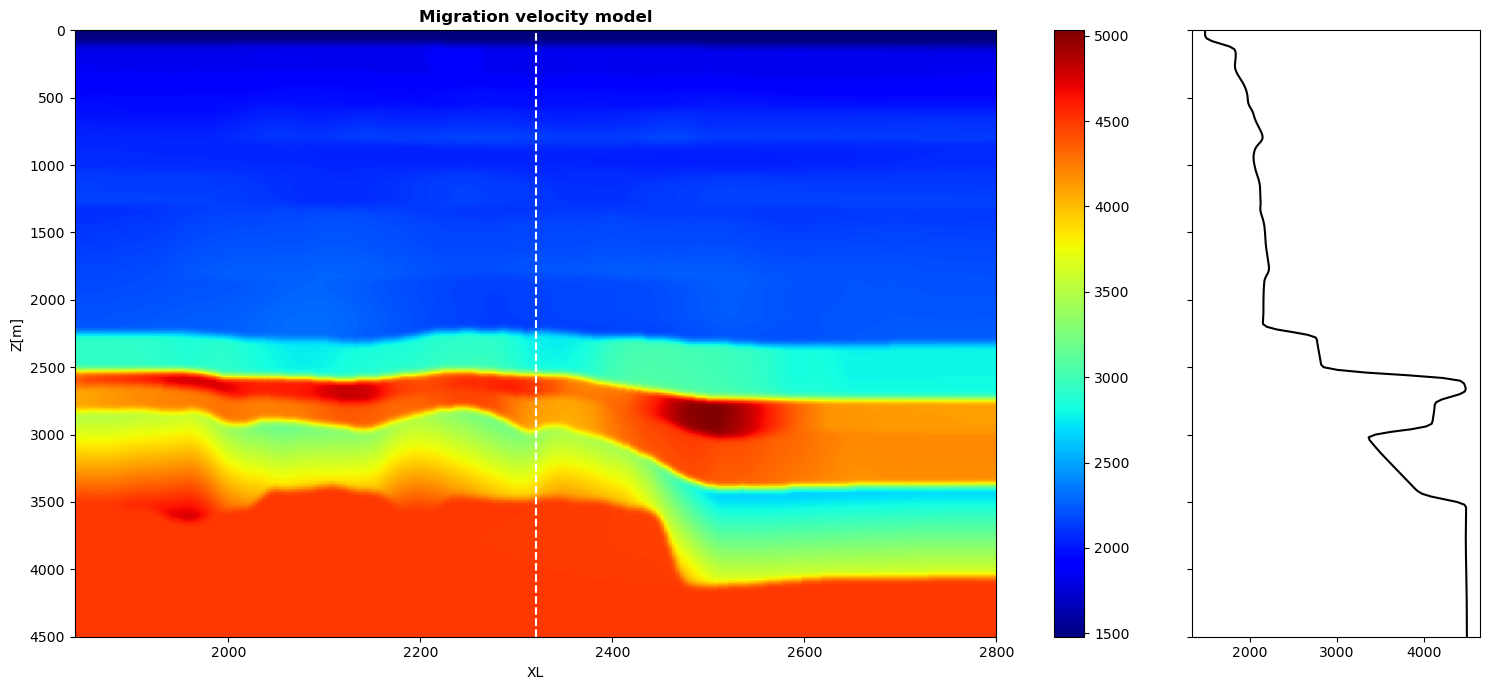

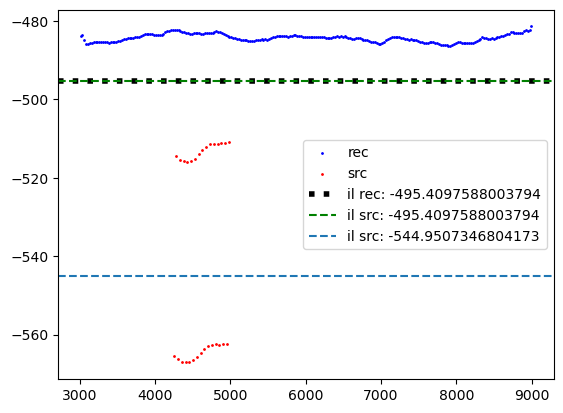

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True, gridspec_kw={'width_ratios': [4, 1]})
im = axs[0].imshow(vmod[50].T, extent=(xl[0], xl[-1], z[-1], z[0]), cmap='jet')
axs[0].axvline(xl[120], color='w', linestyle='--')

axs[0].set_title('Migration velocity model', fontweight='bold')
axs[0].set_xlabel('XL')
axs[0].set_ylabel('Z[m]')
axs[0].axis('tight')
cbar = fig.colorbar(im, ax=axs[0]) 
axs[1].plot(vmod[50, 120], z, 'k')
plt.tight_layout();

plt.figure()
plt.scatter(sg.recx_local, sg.recy_local, color='b', s=1, label='rec')
plt.scatter(sg.srcx_local, sg.srcy_local, c='r', s=1, cmap='jet', label='src')
plt.axhline(v_y[il_rec_idx[0]], linestyle=":", c='black', linewidth=4, label=f"il rec: {v_y[il_rec_idx[0]]}")
plt.axhline(v_y[il_src_idx[1]], linestyle="--", c='g', label=f"il src: {v_y[il_src_idx[1]]}")
plt.axhline(v_y[il_src_idx[0]], linestyle="--", label=f"il src: {v_y[il_src_idx[0]]}")
plt.legend()

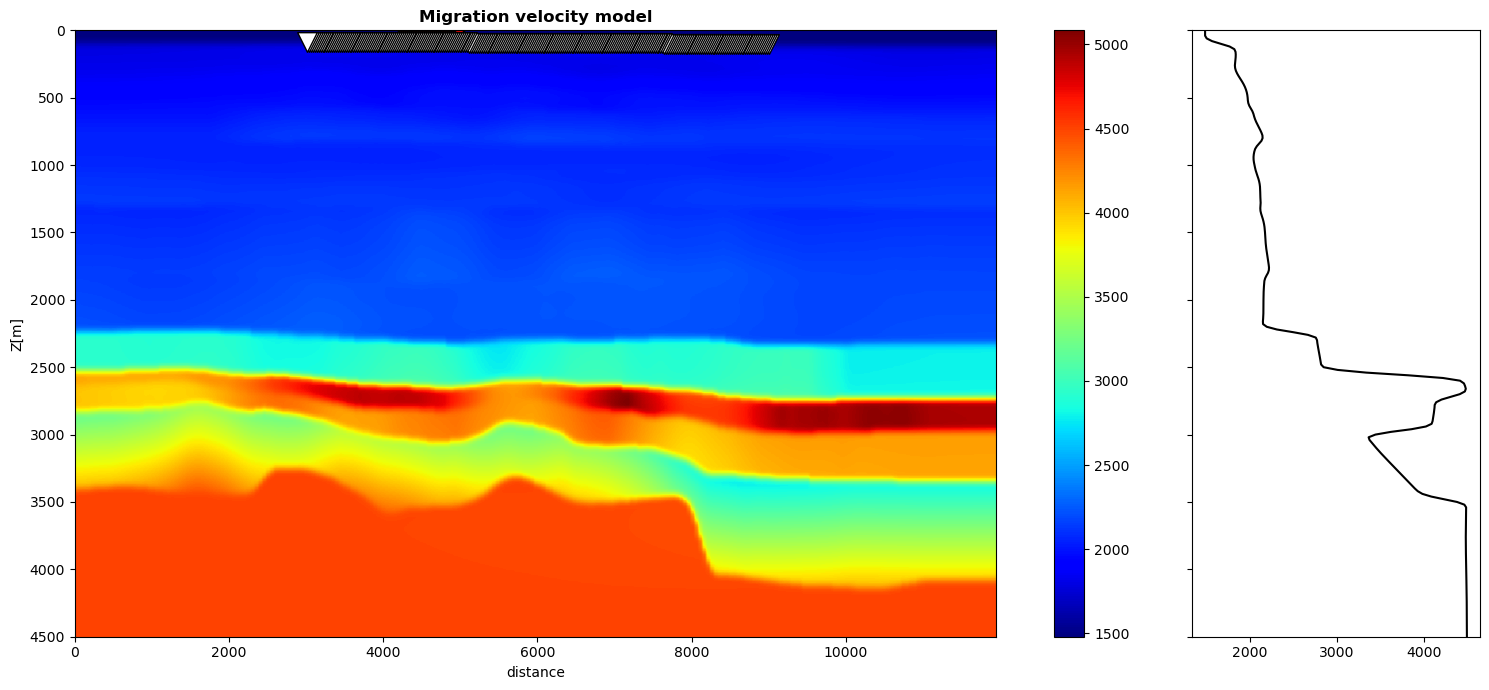

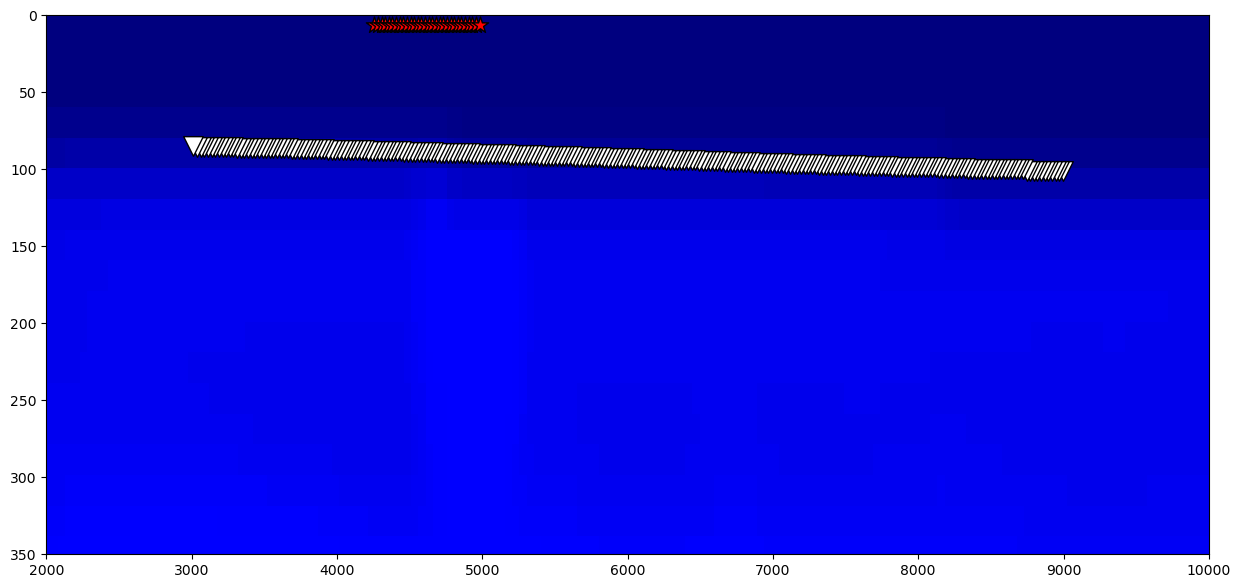

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True, gridspec_kw={'width_ratios': [4, 1]})
im = axs[0].imshow(vmod[il_rec_idx[0]].T, extent=(v_x[0], v_x[-1], z[-1], z[0]), cmap='jet')
# axs[0].axvline(xl[120], color='w', linestyle='--')
axs[0].scatter(sg.srcx_local, sg.srcz, marker='*', s=150, c='r', edgecolors='k')
axs[0].scatter(sg.recx_local, sg.recz, marker='v', s=200, c='w', edgecolors='k')

axs[0].set_title('Migration velocity model', fontweight='bold')
axs[0].set_xlabel('distance')
axs[0].set_ylabel('Z[m]')
axs[0].axis('tight')
cbar = fig.colorbar(im, ax=axs[0]) 
axs[1].plot(vmod[50, 120], z, 'k')
plt.tight_layout();

plt.figure(figsize=(15, 7))
plt.imshow(vmod[50].T, extent=(v_x[0], v_x[-1], z[-1], z[0]), cmap='jet')
plt.scatter(sg.srcx_local, sg.srcz, marker='*', s=150, c='r', edgecolors='k')
plt.scatter(sg.recx_local, sg.recz, marker='v', s=200, c='w', edgecolors='k')

plt.xlim(2000, 10000)
plt.ylim(350, 0) 
plt.gca().set_aspect('auto')
# plt.gca().invert_yaxis() 

Smoothed Velocity model 

In [5]:
# Select the closest inline to geometry of the 2D seismic data
inline = il_rec_idx[0]
vmod2d = vmod[inline, 50:190] # Short it laterally

# Extract the velocity local coordinates
with segyio.open(velfile, "r") as vel:
    scvel = vel.header[0][segyio.TraceField.SourceGroupScalar]
    if scvel < 0:
        scvel = 1. / abs(scvel)
    xvel = scvel * vel.attributes(segyio.TraceField.CDP_X)[xl.size*(inline):xl.size*(inline+1)]
    yvel = scvel * vel.attributes(segyio.TraceField.CDP_Y)[xl.size*(inline):xl.size*(inline+1)]
    rot, ox, oy = segyio.tools.rotation(vel, line='fast')
    ox, oy = scvel * ox, scvel * oy
    rot = (rot - np.pi / 2)

    xvel_local, yvel_local = rotate(xvel, yvel, ox, oy, rot)

# Short laterally the x, y coordiantes
xvel_local = xvel_local[50:190]
yvel_local = yvel_local[50:190]


# Initial velocity (smooth migration velocity)
nsmooth = 5
vel_init = vmod2d.copy()
for _ in range(3):
    vel_init = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_init, axis=1)
    vel_init = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_init, axis=0)
    
    
dx = int(np.mean(np.abs(np.diff(xvel_local))))
dz = z[1] - z[0]
nx = len(xvel_local); 
nz = len(z)

In [6]:
print(f"nx = {nx}, nz = {nz}, velocity model shape ({vel_init.shape[0]}, {vel_init.shape[1]})")

nx = 140, nz = 226, velocity model shape (140, 226)


# one source

## Survey Geometry 

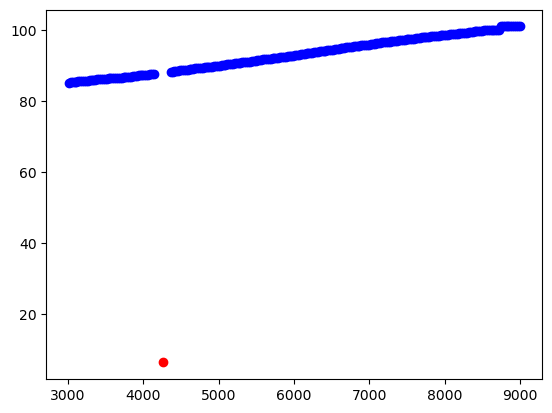

In [7]:
srcs = np.vstack((sg.srcx_local[0], sg.srcz[0]))
recs = np.vstack((sg.recx_local, sg.recz))

survey = survey_geom(srcs, recs, minoffset=100)
display_survey(survey)

## Raytrace

The following is done to truncate the rays to receiver depth

In [28]:
# Lenght and steps of rays
lmax = 6e5
nl = 1000000

# Choose angles to shoot rays, considering the size of the vel. model
thetas = np.hstack([np.arange(-70, -0.5, 0.1), np.arange(0.5, 70, 0.1)])

for s in survey:
    src = s.src
    # Raytrace
    rays, rays_turning, thetas_turning = raytrace(vel_init.T, xvel_local, z, dx, dz, lmax, nl, src, thetas, dzout=.1, debug=False)

In [14]:
sg.recz[0]

101.0

In [15]:
# x, z, px, pz, t
rays_turning[4]

array([[ 4.25695453e+03,  6.30000000e+00, -6.30797585e-04,
         2.42140506e-04,  0.00000000e+00],
       [ 4.25638005e+03,  6.52029466e+00, -6.30797212e-04,
         2.41643046e-04,  3.95294261e-04],
       [ 4.25580557e+03,  6.74013627e+00, -6.30796838e-04,
         2.41145587e-04,  7.90588521e-04],
       ...,
       [ 3.66845652e+03,  6.07760512e-01, -6.30504476e-04,
        -2.55696632e-04,  3.93575962e-01],
       [ 3.66788374e+03,  3.74978629e-01, -6.30504508e-04,
        -2.56201395e-04,  3.93972209e-01],
       [ 3.66767486e+03,  0.00000000e+00, -6.30504540e-04,
        -2.56706164e-04,  3.94368459e-01]])

In [67]:
tolerance_y = 40

# for i in range(len(rays_turning)):
#     condition = np.abs(rays_turning[4][:, 1] - sg.recz[0]) <= tolerance_y
    # if len(condition) != 0:
        # print(i)
        
condition = np.abs(rays_turning[0][:, 1] - sg.recz[0]) <= tolerance_y      
# Get the indices of the rows that satisfy the condition
if len(np.where(condition)[0]) >= 1:
    y_ray_truc_idx = np.where(condition)[0][-1]

In [68]:
rays_turning[90][:y_ray_truc_idx, :]

array([[ 4.25695453e+03,  6.30000000e+00,  5.72379677e-04,
         3.59053094e-04,  0.00000000e+00],
       [ 4.25747580e+03,  6.62676880e+00,  5.72380050e-04,
         3.58555634e-04,  3.95294261e-04],
       [ 4.25799708e+03,  6.95308455e+00,  5.72380424e-04,
         3.58058174e-04,  7.90588521e-04],
       ...,
       [ 5.15657417e+03,  6.18690317e+01,  5.76865720e-04,
        -2.61266300e-04,  5.66066005e-01],
       [ 5.15710946e+03,  6.16269494e+01,  5.76869553e-04,
        -2.61708961e-04,  5.66454163e-01],
       [ 5.15764460e+03,  6.13845309e+01,  5.76873358e-04,
        -2.62151584e-04,  5.66842439e-01]])

Ray tracing

survey_raytrace: 232 Source-receiver pairs in survey, 63 Source-receiver paired with ray...


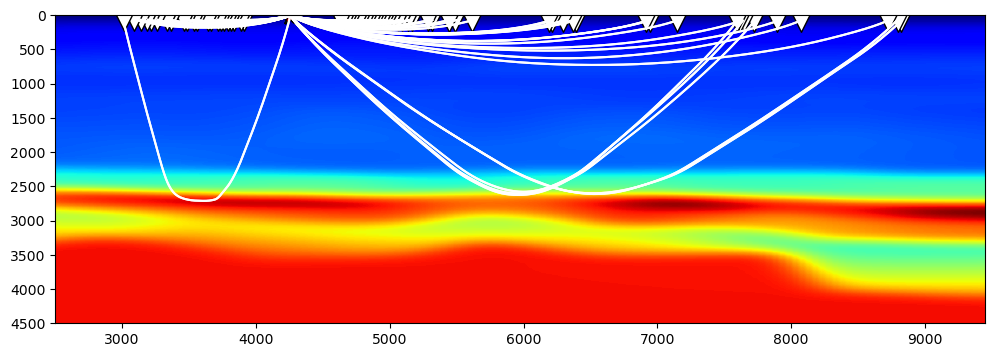

In [58]:
# Lenght and steps of rays
lmax = 6e5
nl = 1000000

# Choose angles to shoot rays, considering the size of the vel. model
thetas = np.hstack([np.arange(-70, -0.5, 0.1), np.arange(0.5, 70, 0.1)])

# Find rays that arrive to the receivers
initsurvey = survey_raytrace(survey, vel_init.T, xvel_local, z,\
     lmax, nl, thetas, dzout=5., ray_rec_mindistance=10., debug=True)

# Display rays
display_survey_rays(initsurvey, vel_init.T, xvel_local, z, figsize=(12, 4))

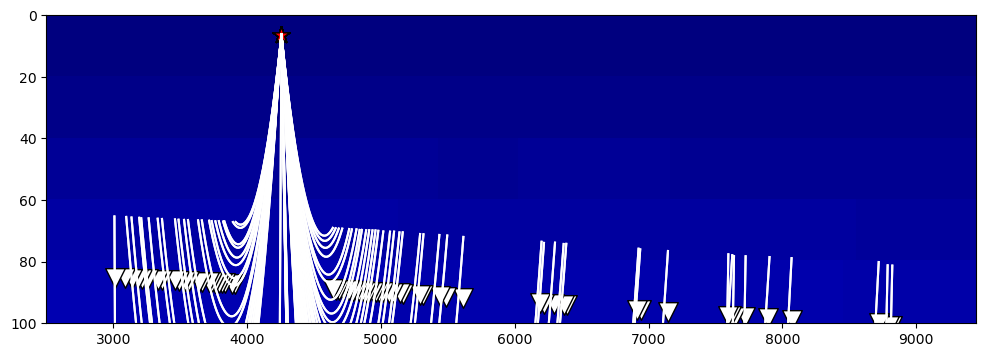

In [61]:
display_survey_rays(initsurvey, vel_init.T, xvel_local, z, figsize=(12, 4))
plt.ylim(100, 0);

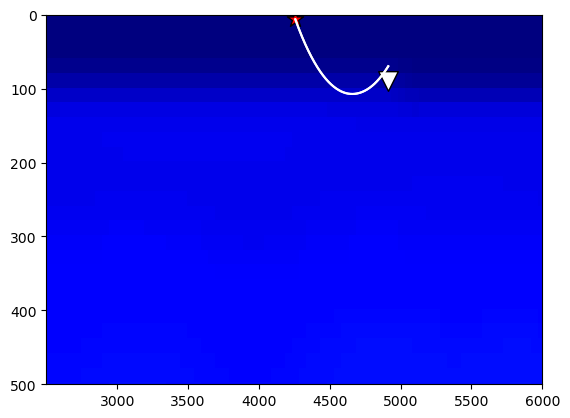

In [59]:
s = initsurvey[30]
src = s.src
plt.imshow(vmod2d.T, cmap='jet', extent = (xvel_local[0], xvel_local[-1], z[-1], z[0]))
plt.scatter(s.src[0], s.src[1], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(s.rec[0], s.rec[1], marker='v', s=200, c='w', edgecolors='k')

for irec, rec in enumerate(s.rec):
    plt.plot(s.ray[:,0], s.ray[:,1], 'w')
plt.axis('tight')

plt.xlim(xvel_local[0], 6000)
plt.ylim(500, 0);

## Create tomographic matrix

In [62]:
# single ray
iray = 40

R = [raytrace_straight(initsurvey[iray].ray[i], initsurvey[iray].ray[i+1], dx, dz, 0., 0., nx, nz, xvel_local, z)[0] 
     for i in range(initsurvey[iray].ray.shape[0]-1)]
R = np.sum(R, axis=0)

(1000.0, 0.0)

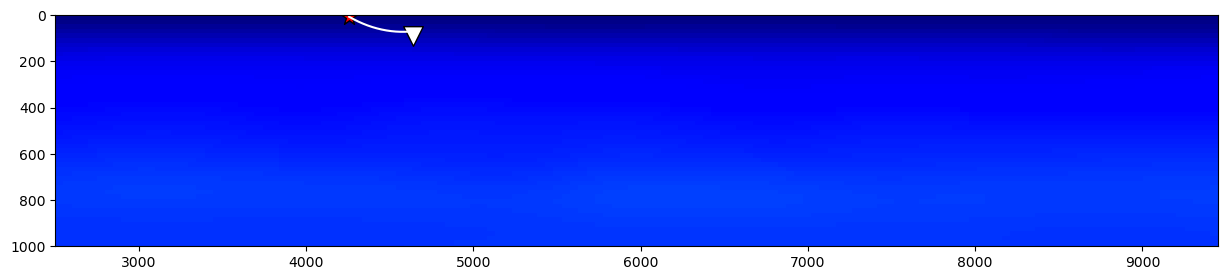

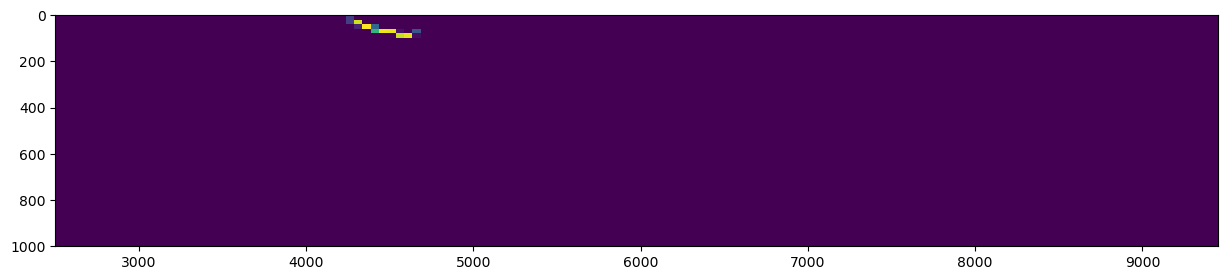

In [64]:
plt.figure(figsize=(15, 3))
plt.imshow(vel_init.T, cmap='jet', extent = (xvel_local[0], xvel_local[-1], z[-1], z[0]))

plt.plot(initsurvey[iray].ray[:,0], initsurvey[iray].ray[:,1], 'w')
plt.scatter(initsurvey[iray].src[0], initsurvey[iray].src[1], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(initsurvey[iray].rec[0], initsurvey[iray].rec[1], marker='v', s=200, c='w', edgecolors='k')
plt.axis('tight');
plt.ylim(1000, 0)
plt.figure(figsize=(15, 3))
plt.imshow(R.reshape(nx, nz).T, extent = (xvel_local[0], xvel_local[-1], z[-1], z[0]))
plt.axis('tight');
plt.ylim(1000, 0)

In [65]:
tobs = extract_tobs(initsurvey)[iray]
tobs_R = R @ (1/vel_init.ravel())

tobs, tobs_R

(0.2493845651648478, 0.24825645090691378)

In [66]:
# multiple rays
iraymax = 20

R = []
Rcove = np.zeros(nx*nz)
for ray in initsurvey[:iraymax]:
    R_ = [raytrace_straight(ray.ray[i], ray.ray[i+1], dx, dz, 0., 0., nx, nz, xvel_local, z)[0] 
         for i in range(ray.ray.shape[0]-1)]
    R.append(np.sum(R_, axis=0))
    Rcove = Rcove + np.sum(R_, axis=0)
R = np.vstack(R)
print(R.shape)

(20, 31640)


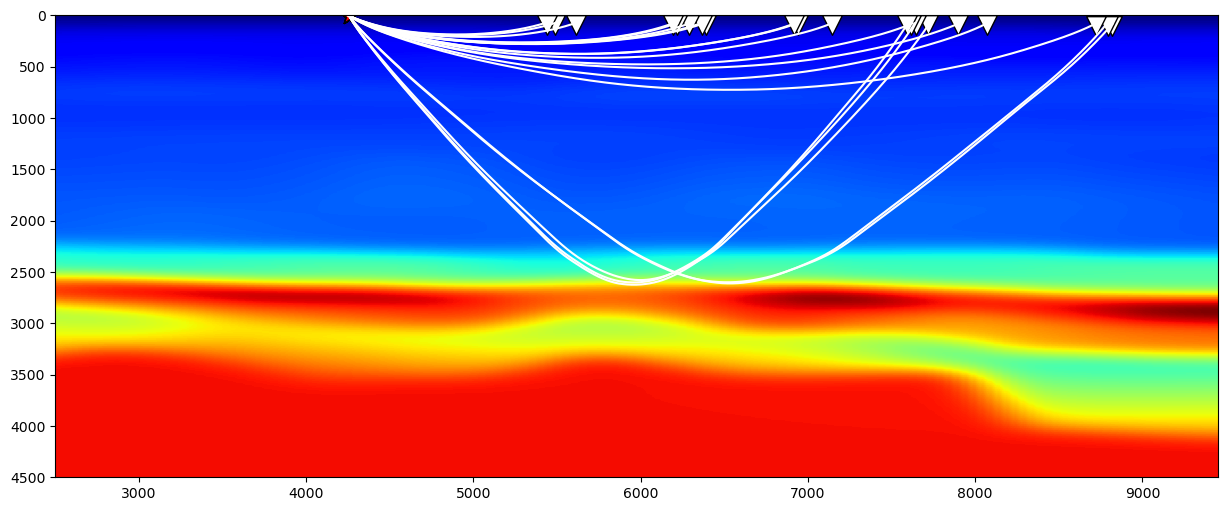

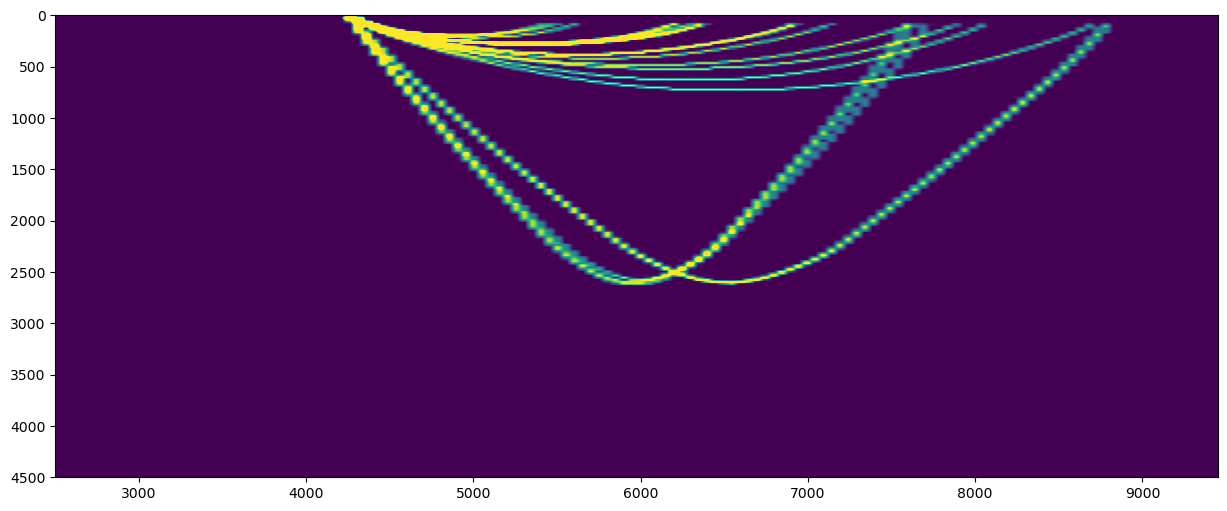

In [70]:
plt.figure(figsize=(15, 6))
plt.imshow(vel_init.T, cmap='jet', extent = (xvel_local[0], xvel_local[-1], z[-1], z[0]))

for ray in initsurvey[:iraymax]:
    plt.plot(ray.ray[:,0], ray.ray[:,1], 'w')
    plt.scatter(ray.src[0], ray.src[1], marker='*', s=150, c='r', edgecolors='k')
    plt.scatter(ray.rec[0], ray.rec[1], marker='v', s=200, c='w', edgecolors='k')
    plt.axis('tight');
# plt.ylim(1000, 0);
plt.figure(figsize=(15, 6))
plt.imshow(Rcove.reshape(nx, nz).T, vmin=0, vmax=np.max(Rcove)/10, extent = (xvel_local[0], xvel_local[-1], z[-1], z[0]))
plt.axis('tight');

# plt.ylim(1000, 0);

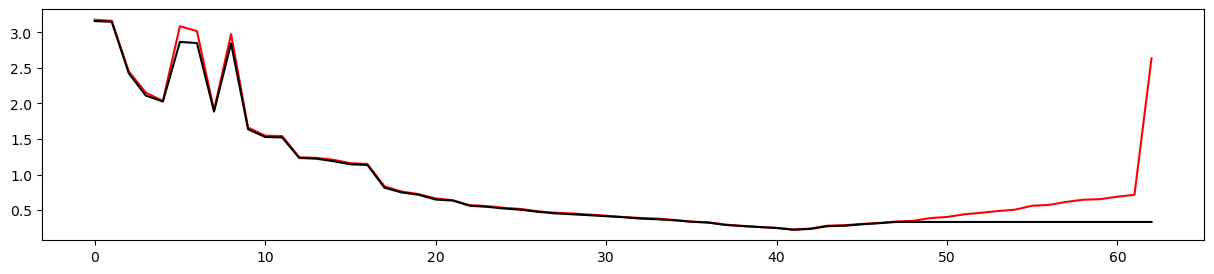

In [90]:
tobs = extract_tobs(initsurvey)
tobs_R = R @ (1/vel_init.ravel())

plt.figure(figsize=(15, 3))
plt.plot(tobs, 'r')
plt.plot(tobs_R, 'k');

Hmm?? why not capturing the edge timing

In [73]:
# all rays
R = []
Rcove = np.zeros(nx*nz)
for iray, ray in enumerate(initsurvey):
    try:
        R_ = [raytrace_straight(ray.ray[i], ray.ray[i+1], dx, dz, 0., 0., nx, nz, xvel_local, z)[0] 
             for i in range(ray.ray.shape[0]-1)]
    except Exception as e:
        print(f" Ray # {iray} An error occurred:", str(e))
    R.append(np.sum(R_, axis=0))
    Rcove = Rcove + np.sum(R_, axis=0)
R = np.vstack(R)

 Ray # 48 An error occurred: index 1098 is out of bounds for axis 0 with size 1098
 Ray # 49 An error occurred: index 1098 is out of bounds for axis 0 with size 1098
 Ray # 50 An error occurred: index 1098 is out of bounds for axis 0 with size 1098
 Ray # 51 An error occurred: index 1098 is out of bounds for axis 0 with size 1098
 Ray # 52 An error occurred: index 1098 is out of bounds for axis 0 with size 1098
 Ray # 53 An error occurred: index 1098 is out of bounds for axis 0 with size 1098
 Ray # 54 An error occurred: index 1098 is out of bounds for axis 0 with size 1098
 Ray # 55 An error occurred: index 1098 is out of bounds for axis 0 with size 1098
 Ray # 56 An error occurred: index 1098 is out of bounds for axis 0 with size 1098
 Ray # 57 An error occurred: index 1098 is out of bounds for axis 0 with size 1098
 Ray # 58 An error occurred: index 1098 is out of bounds for axis 0 with size 1098
 Ray # 59 An error occurred: index 1098 is out of bounds for axis 0 with size 1098
 Ray

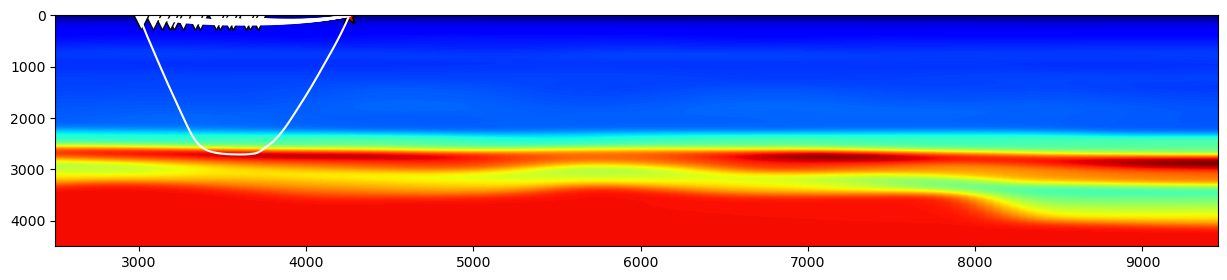

In [75]:
# plot the rays with error:
plt.figure(figsize=(15, 3))
plt.imshow(vel_init.T, cmap='jet', extent = (xvel_local[0], xvel_local[-1], z[-1], z[0]))

for iray, ray in enumerate(initsurvey):
    if iray > 47:
        plt.plot(ray.ray[:,0], ray.ray[:,1], 'w')
        plt.scatter(ray.src[0], ray.src[1], marker='*', s=150, c='r', edgecolors='k')
        plt.scatter(ray.rec[0], ray.rec[1], marker='v', s=200, c='w', edgecolors='k')
        plt.axis('tight');
# plt.xlim(xvel_local[0], 5000)
# plt.ylim(50, 0);

So we have a problem for creating the tomographic matrix for recievers on the left of the source

In [ ]:
R = tomographic_matrix(initsurvey, dx, dz, 0, 0, nx, nz, xvel_local, z, 
                       debug=True, plotflag=True, vel=vmod2d, figsize=(15, 3))

tobs = extract_tobs(initsurvey)
tobs_R = R @ (1/vmod2d.ravel())

plt.figure(figsize=(15, 3))
plt.plot(tobs, 'r')
plt.plot(tobs_R, 'k');

In [ ]:

## not yet needed!! This is for tomo

# 
# data = np.load('../data/FirstArrivalVolvo.npz')
# # Access the data using the key 'tfirst'
# tfirsts = data['tfirst']
# 
# avasurvey = survey_geom_observed(srcs, recs, tobs=tfirsts, minoffset=100)
# # Extract observed data
# tobs = extract_tobs(avasurvey)
# 
# # Display observed data (considering a minimum offset of 100m)
# # With 0m offset would be the same plot as before
# plt.figure(figsize=(12, 4))
# plt.ylabel('Time [s]')
# plt.xlabel('Traces')
# plt.plot(tobs, 'k')
# plt.grid(which='both')
# plt.title('Observed data')
# 
# plt.show()
# 
# 
# 
# 
# 
# # ------------------------------
# 
# # Match surveys
# avasurvey_matched, initsurvey_matched = match_surveys(avasurvey, initsurvey)
# 
# dx = int(np.mean(np.abs(np.diff(xvel_local)))); dz = z[1] - z[0]
# nx = len(xvel_local); nz = len(z)
# 
# # Tomographic matrix and traveltimes
# Rinit = tomographic_matrix(initsurvey_matched, dx, dz, 0, 0, nx, nz, xvel_local, z, plotflag=True, vel=vel_init)
# tinit = Rinit @ (1. / vel_init.ravel())
# 
# # Observed traveltimes
# tobs = extract_tobs(avasurvey_matched)
# 
# plt.figure(figsize=(15, 3))
# plt.plot(tobs, 'k')
# plt.plot(tinit, 'r');